# Download The Data

In [ ]:
!pip install mxnet
!pip install gluoncv

     |████████████████████████████████| 47.3 MB 1.6 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 1.3 MB 26.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gluoncv import model_zoo,data, utils
from matplotlib import pyplot as plt
from gluoncv.data import VOCDetection
import pickle
import numpy as np
import os
from matplotlib import pyplot as plt
from gluoncv.utils import viz

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [ ]:
def download_voc(path, overwrite=False):
    _DOWNLOAD_URLS = [
                      ('http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar',
         '34ed68851bce2a36e2a223fa52c661d592c66b3c'),
        ('http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar',
         '41a8d6e12baa5ab18ee7f8f8029b9e11805b4ef1'),
        ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar',
         '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')]
    makedirs(path)
    for url, checksum in _DOWNLOAD_URLS:
        filename = download(url, path=path, overwrite=overwrite, sha1_hash=checksum)
        # extract
        with tarfile.open(filename) as tar:
            tar.extractall(path=path)

In [ ]:
path ="/content/drive/MyDrive"
if not (os.path.exists(os.path.join(path, 'VOC2007')) or os.path.exists(os.path.join(path, 'VOC2012'))):
        #Datset Not available, download it
        os.mkdir(path)
        download_voc(path)
        shutil.move(os.path.join(path, 'VOCdevkit', 'VOC2007'), os.path.join(path, 'VOC2007'))
        shutil.move(os.path.join(path, 'VOCdevkit', 'VOC2012'), os.path.join(path, 'VOC2012'))
        shutil.rmtree(os.path.join(path, 'VOCdevkit'))
else:
  print("Dataset Found")


Dataset Found


In [ ]:
net = model_zoo.get_model('ssd_512_resnet50_v1_voc', pretrained=True)

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


100%|██████████| 132723/132723 [00:06<00:00, 20339.25KB/s]


In [ ]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/detection/street_small.jpg?raw=true',
                          path='street_small.jpg')
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

117KB [00:00, 13365.66KB/s]            

Shape of pre-processed image: (1, 3, 512, 512)


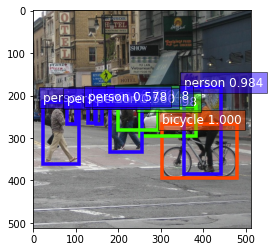

In [ ]:
class_IDs, scores, bounding_boxes = net(x)
ax = utils.viz.plot_bbox(img, bounding_boxes[0], scores[0],
                         class_IDs[0], class_names=net.classes)
plt.show()

In [ ]:
bounding_boxes.shape

(1, 100, 4)

In [ ]:
scores.shape

(1, 100, 1)

In [ ]:
pkl_path_train=os.path.join(path,"train_data.pickle")
pkl_path_val=os.path.join(path,"val_data.pickle")

if not os.path.exists(pkl_path_train):
    train_dataset = VOCDetection(root=path,splits=[(2007, 'trainval'), (2012, 'trainval')])
    print('Training images:', len(train_dataset))
    pkl_path_train=os.path.join(path,"train_data.pickle")
    with open(pkl_path_train, 'wb') as handle:
        pickle.dump(train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Train DataSet pickle file is already available")
    with open('/content/drive/MyDrive/train_data.pickle', 'rb') as handle:
      train_data = pickle.load(handle)
    print("Total images in training set =",len(train_data))


if not os.path.exists(pkl_path_val):
    val_dataset = VOCDetection(root=path,splits=[(2007, 'test')])
    print('Validation images:', len(val_dataset))
    pkl_path_val=os.path.join(path,"val_data.pickle")
    with open(pkl_path_val, 'wb') as handle:
        pickle.dump(val_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Validation DataSet pickle file is already ")
    with open('/content/drive/MyDrive/val_data.pickle', 'rb') as handle:
      val_data = pickle.load(handle)
    print("Total images in validation set =",len(val_data))



Train DataSet pickle file is already available
Total images in training set = 16551
Validation DataSet pickle file is already 
Total images in validation set = 4952


In [ ]:
CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
               'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

In [ ]:
def make_index_pickle(InvIndex_path,ImageBB_path,train_dataset):
    InvIndex={}
    ImageBB=[]
    for i in range(len(train_dataset)):
        if i%400==0:
            print(i)
        train_image, train_label = train_dataset[i]
        bboxes = train_label[:, :4]
        cids = train_label[:, 4:5]
        ImageBB.append(bboxes)
        for idx,classID in enumerate(cids):
            if int(classID.item()) in InvIndex:
                if i not in InvIndex[int(classID.item())]:
                    InvIndex[int(classID.item())].append([i,bboxes[idx]])
                else:
                    InvIndex[int(classID.item())]=[[i,bboxes[idx]]]
    with open(InvIndex_path, 'wb') as handle:
        pickle.dump(InvIndex, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(ImageBB_path, 'wb') as handle:
        pickle.dump(ImageBB, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return InvIndex,ImageBB


In [ ]:
InvIndex_path=os.path.join(path,"CBIR_InvIndex.pickle")
ImageBB_path=os.path.join(path,"CBIR_ImageBB.pickle")

if not (os.path.exists(InvIndex_path) or os.path.exists(ImageBB_path)):
    InvIndex,ImageBB= make_index_pickle(InvIndex_path,ImageBB_path,train_dataset)
else:
    print("Inverted Index and Bounding Box pickle files are already available")
    with open('/content/drive/MyDrive/CBIR_InvIndex.pickle', 'rb') as handle:
      testing_load = pickle.load(handle)
    with open('/content/drive/MyDrive/CBIR_ImageBB.pickle', 'rb') as handle:
      t = pickle.load(handle)

Inverted Index and Bounding Box pickle files are already available


In [ ]:
print((testing_load[8]))

[[0, array([262., 210., 323., 338.])], [0, array([164., 263., 252., 371.])], [0, array([  4., 243.,  66., 373.])], [0, array([240., 193., 294., 298.])], [0, array([276., 185., 311., 219.])], [21, array([  0.,   0., 369., 329.])], [23, array([438., 169., 486., 229.])], [25, array([404., 152., 492., 254.])], [25, array([274., 128., 311., 169.])], [30, array([ 74.,   0., 427., 374.])], [40, array([ 21.,  50., 316., 290.])], [42, array([ 52.,   2., 499., 337.])], [45, array([184.,  57., 347., 185.])], [51, array([286., 161., 315., 197.])], [72, array([ 32., 104.,  64., 145.])], [72, array([ 76., 113., 113., 148.])], [72, array([145., 124., 174., 149.])], [72, array([226., 131., 246., 153.])], [72, array([301., 126., 326., 152.])], [72, array([372., 120., 401., 152.])], [72, array([434., 111., 464., 148.])], [95, array([  1., 211.,  48., 374.])], [100, array([ 51., 165., 166., 331.])], [102, array([329., 222., 499., 374.])], [102, array([116., 113., 179., 218.])], [102, array([ 58., 121., 1

In [ ]:
def make_final_index_pickle(InvIndex_final_path,train_dataset):
    InvIndex_final_version={}
    for i in range(len(train_dataset)):
        if i%400==0:
            print(i)
        train_image, train_label = train_dataset[i]
        bboxes = train_label[:, :4]
        cids = train_label[:, 4:5]
        lis=[]
        for j in cids:
            lis.append(int(j[0]))
        # print(cids)
        # print(lis)
        InvIndex_final_version[int(i)]= return_vector(lis)
    with open(InvIndex_final_path, 'wb') as handle:
        pickle.dump(InvIndex_final_version, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return InvIndex_final_version

def return_vector(a):
  l=[]
  d={}
  for i in a:
    if(i in d.keys()):
      d[i]=d[i]+1
    else:
      d[i]=1
  for i in range(20):
    if(i in d.keys()):
      l.append(d[i])
    else:
      l.append(0)
  return l

InvIndex_final_path=os.path.join(path,"InvIndex_final_version")

if not os.path.exists(InvIndex_final_path):
    InvIndex_final_version=make_final_index_pickle(InvIndex_final_path,train_data)
else:
    print("Final Inverted Index pickle file is already avaiable")
    with open('/content/drive/MyDrive/InvIndex_final_version', 'rb') as handle:
      InvIndex_final_version = pickle.load(handle)
  


Final Inverted Index pickle file is already avaiable


In [ ]:
print((InvIndex_final_version[0]))

[0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Run The Program From Here

In [ ]:
def reverse_count(l):
  d1={}
  # A dictionary of Image Id : count
  d2={}
  for i in l:
    if(i in d1.keys()):
      d1[i]=d1[i]+1
    else:
      d1[i]=1

  for k,v in d1.items():
    if(v in d2.keys()):
      d2[v].append(k)
    else:
      d2[v]=[]
      d2[v].append(k)
  return d2

for k,v in testing_load.items():
  lis_images=[]
  for i in range(len(v)):
    lis_images.append(v[i][0])
  testing_load[k]=reverse_count(lis_images)

#Taking User Input 
####  User can make a query with any image from the validation set. We can simulate taking image as input as taking an integer input representing the image index in the validation set.

Provide an integer between 0 and 4951	493


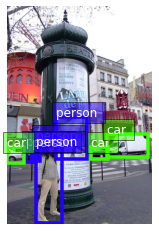

In [ ]:
idx=int(input('Provide an integer between 0 and 4951\t'))
val_image, val_label = val_data[idx]
bboxes_Q = val_label[:, :4]
cids_Q = val_label[:, 4:5]
ax = viz.plot_bbox(
    val_image.asnumpy(),
    bboxes_Q,
    labels=cids_Q,
    class_names=train_data.classes)
ax.set_axis_off()
plt.savefig('/content/drive/MyDrive/input_image_G.png', format='png')
plt.show()

In [ ]:
cids_Q


array([[9.]])

#-----------------------------------------OR------------------------------------

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Provide an integer between 0 and 4951	493
Image Size:  (769, 512, 3)


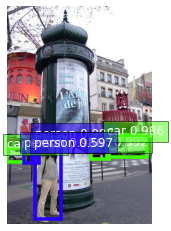

In [ ]:
#Pretrained Model
net = model_zoo.get_model('ssd_512_resnet50_v1_voc', pretrained=True)

threshold=0.5
idx=int(input('Provide an integer between 0 and 4951\t'))
val_image, _ = val_data[idx]
x, img = data.transforms.presets.ssd.transform_test(val_image,short=512)
print("Image Size: ",img.shape)
cids_Q, scores, bboxes = net(x)
n=int(sum(scores[0]>0.5).max().asnumpy()[0])

if n<3:
  #n+=1
  threshold=0.25
  n=int(sum(scores[0]>0.25).max().asnumpy()[0])

cids_Q=cids_Q[0][:n]
bboxes_Q=bboxes[0][:n]
scores=scores[0][:n]
ax = utils.viz.plot_bbox(img, bboxes_Q, scores,cids_Q, thresh=threshold,class_names=net.classes)
#ax = utils.viz.plot_bbox(img, bboxes[0], scores[0],cids[0], class_names=net.clas
ax.set_axis_off()
plt.savefig('/content/drive/MyDrive/input_image_P.png', format='png')
plt.show()

In [ ]:
cids_Q=cids_Q.asnumpy()
bboxes_Q=bboxes_Q.asnumpy()
cids_Q

array([[14.],
       [ 6.],
       [ 6.],
       [14.],
       [ 6.],
       [14.]], dtype=float32)

# Phase 1: Image Retrieval
#### 1. Postings List for a class is stored in the form of list of [image_index,one BB]. Thus for each BB there is an entry in the postings list of corresponding class.
#### 2. One image can be repeated in a single class' postings list because of several instances of the same object in the image
#### 3. We have to keep the count of the occurances of all images and group them based on the number of occurence. We have to count the repetition of images for a single class.
#### 4. Retrieve image only from training set and not validation set.
#### 5. These grouped images will be sent to Phase 2


#Find A Superset of Actual Images Ids Using Inverted Index

In [ ]:
lis_Query=[]
for i in cids_Q:
  lis_Query.append(int(i[0]))
cid_dict={}
for i in lis_Query:
  if(i in cid_dict.keys()):
    cid_dict[i]=cid_dict[i]+1
  else:
    cid_dict[i]=1

print(cid_dict)

{14: 3, 6: 3}


In [ ]:
imagesIDs=[]
for classID,count in cid_dict.items():
  imagesIDs=imagesIDs+testing_load[classID][count] 
print(len(imagesIDs))

913


In [ ]:
imagesIDs_dict=reverse_count(imagesIDs)
intermediate_ans=imagesIDs_dict[max(list(imagesIDs_dict.keys()))]

# Generate Query Vector For Query Image

In [ ]:
Query_vector=[]
for i in cids_Q:
  Query_vector.append(int(i[0]))
Query_vector=return_vector(Query_vector)
print(Query_vector)

[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0]


## Calculate Euclidean Distance Similarity between the Images and Query

In [ ]:
b=np.array(Query_vector)
def euclidean_sim(intermediate_ans,b):
  similarity=[]
  for i in intermediate_ans:
    a=np.array(InvIndex_final_version[i])
    similarity.append((i,np.linalg.norm(a-b)))  
  similarity.sort(key=lambda x:x[1])
  return similarity
def cosine_sim(intermediate_ans,b):
  similarity=[]
  for i in intermediate_ans:
    a=np.array(InvIndex_final_version[i])
    similarity.append((i,np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))))  
  similarity.sort(key=lambda x:x[1],reverse=True)
  return similarity
def dot_sim(intermediate_ans,b):
  similarity=[]
  for i in intermediate_ans:
    a=np.array(InvIndex_final_version[i])
    similarity.append((i,np.dot(a, b)))  
  similarity.sort(key=lambda x:x[1],reverse=True)
  return similarity


### Top 10 similar Images Retrieval

Score:  0.7324577876650697
Score:  0.7505183475944152
Score:  0.4490874452224982
Score:  0.8383444745523703
Score:  0.8409022067004431
Score:  0.5834817163056385
Score:  5.650491210552056
Score:  0.042299588289819945
Score:  1.1148215728064086
Score:  0.37944309016868294
Score:  0.38926161232305556
Score:  0.5989141002257448
Score:  5.598420204427281
Score:  0.049798045535314306
Score:  1.0982632640162722
Score:  0.38430183242238725
Score:  0.39404347900305403
Score:  0.5863951654177799
Score:  7.197068186888936
Score:  0.18041439780330126
Score:  1.6066249975479376
Score:  0.23513209134665647
Score:  0.2472339185720157
Score:  0.9707428353161658
Score:  2.244588522176385
Score:  0.5327647740383212
Score:  0.03176225399583554
Score:  0.6972476523536671
Score:  0.7020378345038616
Score:  0.21993456223096142
Score:  7.726891879370536
Score:  0.2567113738249138
Score:  1.7751061727228197
Score:  0.18569427646162529
Score:  0.19857831442869456
Score:  1.098123286732803
image: (333, 500, 3)

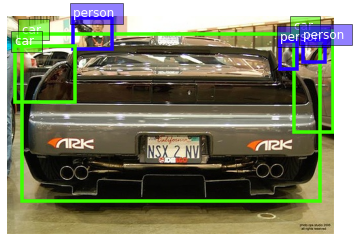

Score:  0.441025506781351
Score:  0.47300814944526093
Score:  0.4778346223422534
Score:  0.4920740296335968
Score:  0.05604921905040339
Score:  0.010843246761383263
Score:  1.1457694268462593
Score:  4.6545260846789125
Score:  4.673053760105092
Score:  0.9498063534844046
Score:  2.623601346362325
Score:  2.8803855284075417
Score:  1.1289688072483588
Score:  4.610253135047636
Score:  4.62863574529441
Score:  0.9345400557990065
Score:  2.5952298228272217
Score:  2.8500034750795704
Score:  1.6447697994537034
Score:  5.96949058546423
Score:  5.99232688642377
Score:  1.4032353588230988
Score:  3.466272697437171
Score:  3.782772243545799
Score:  0.046860845787727534
Score:  1.7586850131590843
Score:  1.7677241474316037
Score:  0.04874405292884476
Score:  0.7678536765367951
Score:  0.8931314918684543
Score:  1.8157164927057705
Score:  6.419968872641669
Score:  6.444281215159135
Score:  1.5585702911042043
Score:  3.7549536060540873
Score:  4.091910339338032
image: (375, 500, 3)
bboxes: (6, 4) 

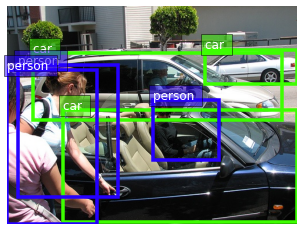

Score:  0.6999030812076044
Score:  0.8575142395359161
Score:  0.8157347948678999
Score:  0.8639147806258386
Score:  0.8671689326544594
Score:  0.9109463997099475
Score:  0.15200031709426032
Score:  0.4530312343873326
Score:  0.2926499359079817
Score:  0.4776013812413442
Score:  0.4900932928008813
Score:  0.6581445214920829
Score:  0.1429805599563243
Score:  0.4573138073646621
Score:  0.2981882380203512
Score:  0.48169157861410306
Score:  0.4940856829015555
Score:  0.6608211296029138
Score:  0.419898899431139
Score:  0.32583321654321395
Score:  0.12815512060781664
Score:  0.3561171704268985
Score:  0.371514085872128
Score:  0.5786457603395088
Score:  0.4379712884279834
Score:  0.7331492482720642
Score:  0.6549037016285026
Score:  0.745136335232532
Score:  0.7512307892484711
Score:  0.8332182801700401
Score:  0.5116751370682064
Score:  0.2822579373804963
Score:  0.07180276843273281
Score:  0.31449931749314164
Score:  0.3308914241955411
Score:  0.5514112108628102
image: (333, 500, 3)
bbox

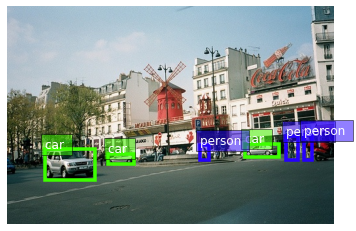

Score:  0.5644182947644389
Score:  0.0476561242336927
Score:  0.16101657725834018
Score:  0.8127609212709002
Score:  0.6136037565376001
Score:  0.24915647774580973
Score:  0.6720940173962902
Score:  2.6558204305473967
Score:  2.2206567562389488
Score:  0.2812339462319532
Score:  0.4832827900530752
Score:  3.7952130406877966
Score:  0.6590021095860978
Score:  2.6271966429197895
Score:  2.1954401470637
Score:  0.28686163152663524
Score:  0.47166920771752063
Score:  3.7576682098315315
Score:  1.060940799942609
Score:  3.505984355061063
Score:  2.969623025073323
Score:  0.1140843335286984
Score:  0.8282213727630265
Score:  4.91034361534237
Score:  0.184232128863538
Score:  0.783572465936299
Score:  0.5712682889622662
Score:  0.6493341597857354
Score:  0.276347842079401
Score:  1.3394502301604634
Score:  1.1941512649181356
Score:  3.797232056657756
Score:  3.2262026070595207
Score:  0.056822505404847234
Score:  0.9463898418188774
Score:  5.292363138264532
image: (483, 500, 3)
bboxes: (6, 4)

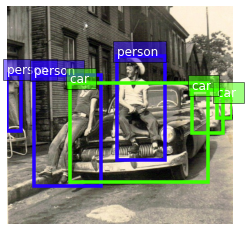

Score:  0.8557972518292223
Score:  0.6921304320650326
Score:  0.5532604395898568
Score:  0.5913158674709696
Score:  0.6410782172522344
Score:  0.5606052803676864
Score:  0.44644012911868247
Score:  0.1818376586868926
Score:  0.7149263555320331
Score:  0.568840667073073
Score:  0.3778149046025483
Score:  0.686731267961274
Score:  0.4507743081311073
Score:  0.17258428566290718
Score:  0.7014990855853018
Score:  0.5565571966650011
Score:  0.36702709869995087
Score:  0.6735247556294472
Score:  0.31770934454585475
Score:  0.4566749383442106
Score:  1.1137338320942032
Score:  0.933675801564559
Score:  0.6982268473671804
Score:  1.0789819546710566
Score:  0.7299336324887988
Score:  0.42341448457714814
Score:  0.16333542991403682
Score:  0.23460654854601404
Score:  0.3278026714682496
Score:  0.17709102399236498
Score:  0.27360897278164165
Score:  0.5508282230287747
Score:  1.250356614570833
Score:  1.058660397262559
Score:  0.8079930221054383
Score:  1.2133585233066881
image: (375, 500, 3)
bbo

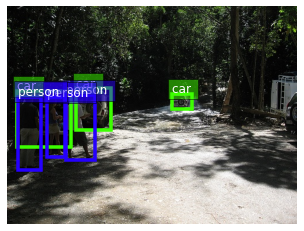

Score:  0.43367665869695093
Score:  0.3176474835228381
Score:  0.5018045846476296
Score:  0.9038585134057227
Score:  0.9064535153007812
Score:  0.8830668941259766
Score:  1.1739798975087825
Score:  1.6193881580488787
Score:  0.9124530793928982
Score:  0.6309358207068416
Score:  0.6408974125085748
Score:  0.5511217656357185
Score:  1.1569583998517814
Score:  1.5988792704340034
Score:  0.897479244700446
Score:  0.6338254633711184
Score:  0.6437090594141477
Score:  0.5546363242676846
Score:  1.6795406373187358
Score:  2.2285289401463233
Score:  1.3571955513806326
Score:  0.5451096547268277
Score:  0.557387822558882
Score:  0.4467347781986025
Score:  0.060623944845972444
Score:  0.2779261687084684
Score:  0.0669676698837417
Score:  0.8199439165965565
Score:  0.8248038984233466
Score:  0.7810048730291831
Score:  1.8527347699342815
Score:  2.437207346297443
Score:  1.5095546659395769
Score:  0.5157074737382206
Score:  0.5287792502202667
Score:  0.41097406277533344
image: (375, 500, 3)
bboxes

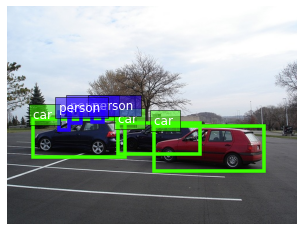

Score:  0.1347961537775204
Score:  0.08033766257418162
Score:  0.6062981969020443
Score:  0.3797473008913327
Score:  0.45029001954618175
Score:  0.4438407758364554
Score:  2.3213106925932445
Score:  2.530363819120417
Score:  0.5113270867108939
Score:  1.3810018074396226
Score:  1.110205177517221
Score:  1.1349622820837046
Score:  2.295305998512618
Score:  2.5027223126168936
Score:  0.4994939274002257
Score:  1.3623594010709663
Score:  1.093683013477866
Score:  1.1182462786266734
Score:  3.09368411371379
Score:  3.35135270969759
Score:  0.8627873927274976
Score:  1.9347056556846822
Score:  1.6009350558932427
Score:  1.6314494446528904
Score:  0.6203745273238552
Score:  0.7223656966045446
Score:  0.26266581466703565
Score:  0.16162414040068263
Score:  0.029510043941733066
Score:  0.04158834233738862
Score:  3.3582824778521134
Score:  3.6326056781222418
Score:  0.9831900625871508
Score:  2.1243925719565864
Score:  1.7690484573923713
Score:  1.8015351667132062
image: (333, 500, 3)
bboxes: 

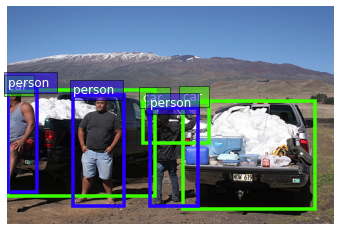

Score:  0.5784565587789379
Score:  0.6645181244782168
Score:  0.7623983740832189
Score:  0.39458004415905057
Score:  0.7845382582411019
Score:  0.5645527213935118
Score:  0.6182044784392327
Score:  0.28783470532008915
Score:  0.08790416942734824
Score:  1.3240624525920324
Score:  0.17289389099111985
Score:  5.005943807783225
Score:  0.6055345067574036
Score:  0.277751412717278
Score:  0.09504555884904597
Score:  1.3058658613370486
Score:  0.1793698407976101
Score:  4.958919381030516
Score:  0.9945192061977555
Score:  0.5873216817731122
Score:  0.1242044353533549
Score:  1.8645250089585255
Score:  0.019450287007505063
Score:  6.402630777243866
Score:  0.21052332661567086
Score:  0.3717014922578761
Score:  0.555013972756562
Score:  0.13384502283632993
Score:  0.5964780791448613
Score:  1.9301318844916096
Score:  1.1234364613016479
Score:  0.6899194173803744
Score:  0.1968682380036495
Score:  2.0496757461306054
Score:  0.08534322617173817
Score:  6.881105407813682
image: (375, 500, 3)
bbo

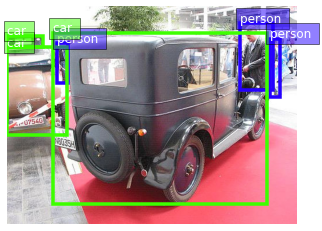

Score:  0.26989568325426516
Score:  0.7623063161076931
Score:  0.6898471978050238
Score:  0.5049432883060062
Score:  0.6523643463592724
Score:  0.707153181618964
Score:  3.8748258918232388
Score:  0.08755078087066626
Score:  0.19060244908232526
Score:  0.9004043465226477
Score:  0.3344901535108218
Score:  0.1241689151376495
Score:  3.836657720355305
Score:  0.09469493720041888
Score:  0.1812804508335386
Score:  0.8855248491690808
Score:  0.32404156516494753
Score:  0.11536706808422625
Score:  5.00847049780098
Score:  0.12464000469761505
Score:  0.4674779876589976
Score:  1.3423448761784238
Score:  0.6448268912383168
Score:  0.3855952829985543
Score:  1.3782911119590802
Score:  0.5548415643706882
Score:  0.41913838865942377
Score:  0.07284590942122982
Score:  0.3489396049169138
Score:  0.4515494504743026
Score:  5.396832525873835
Score:  0.19733196070140724
Score:  0.5623295355942171
Score:  1.4937441061308125
Score:  0.7511415194858668
Score:  0.4751542804822635
image: (334, 500, 3)
bb

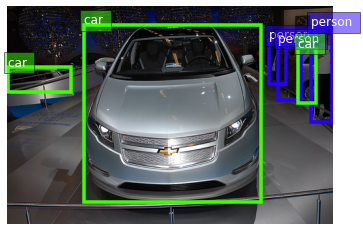

Score:  0.0815142899074508
Score:  0.7306575926659007
Score:  0.767705976464272
Score:  0.8178243755262203
Score:  0.7007608938295091
Score:  0.7793710570943371
Score:  3.151674765368928
Score:  0.03394110110962045
Score:  0.10827878590321183
Score:  0.3006713364297394
Score:  0.14870737954455704
Score:  0.15305824128329715
Score:  3.11916861277187
Score:  0.02584570609231518
Score:  0.1152606492469529
Score:  0.3061468337984481
Score:  0.1397134049489761
Score:  0.15968949724759218
Score:  4.117150006531664
Score:  0.27438491965453693
Score:  0.09909168574632243
Score:  0.13804190414748496
Score:  0.41584018665707223
Score:  0.04389873269949929
Score:  1.025485917514231
Score:  0.49556907556784613
Score:  0.5649541778735079
Score:  0.6588171184334719
Score:  0.4395778204930223
Score:  0.5868008208289947
Score:  4.447900861548259
Score:  0.3567557513202051
Score:  0.1701323068612426
Score:  0.08232859169274065
Score:  0.5073540863289492
Score:  0.11137191561389237
image: (375, 500, 3)


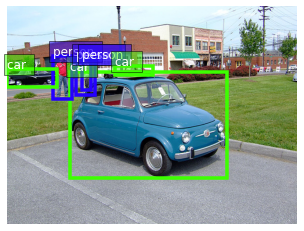

In [ ]:
l=10
similarity=euclidean_sim(intermediate_ans,b)
if(l>len(similarity)):
  l=len(similarity)
for i in range(0,l):
  train_image, train_label = train_data[similarity[i][0]]
  bboxes = train_label[:, :4]
  cids = train_label[:, 4:5]
  for q_idx,qc in enumerate(cids_Q):
    for r_idx,rc in enumerate(cids):
      qbox=bboxes_Q[q_idx]
      ql=np.linalg.norm(np.array([qbox[0],qbox[1]])-np.array([qbox[2],qbox[3]]))
      rbox=bboxes[r_idx]
      rl=np.linalg.norm(np.array([rbox[0],rbox[1]])-np.array([rbox[2],rbox[3]]))
      #print("Score: ",np.sqrt(((1 - rl/ql) ** 2)))
  print('image:', train_image.shape)
  print('bboxes:', bboxes.shape, 'class ids:', cids.shape)
  ax = viz.plot_bbox(
      train_image.asnumpy(),
      bboxes,
      labels=cids,
      class_names=train_data.classes)
  ax.set_axis_off()
  plt.savefig('/content/drive/MyDrive/input_image_R_EUC_{}.png'.format(i), format='png')
  plt.show()

Score:  0.7324577876650697
Score:  0.7505183475944152
Score:  0.4490874452224982
Score:  0.8383444745523703
Score:  0.8409022067004431
Score:  0.5834817163056385
Score:  5.650491210552056
Score:  0.042299588289819945
Score:  1.1148215728064086
Score:  0.37944309016868294
Score:  0.38926161232305556
Score:  0.5989141002257448
Score:  5.598420204427281
Score:  0.049798045535314306
Score:  1.0982632640162722
Score:  0.38430183242238725
Score:  0.39404347900305403
Score:  0.5863951654177799
Score:  7.197068186888936
Score:  0.18041439780330126
Score:  1.6066249975479376
Score:  0.23513209134665647
Score:  0.2472339185720157
Score:  0.9707428353161658
Score:  2.244588522176385
Score:  0.5327647740383212
Score:  0.03176225399583554
Score:  0.6972476523536671
Score:  0.7020378345038616
Score:  0.21993456223096142
Score:  7.726891879370536
Score:  0.2567113738249138
Score:  1.7751061727228197
Score:  0.18569427646162529
Score:  0.19857831442869456
Score:  1.098123286732803
image: (333, 500, 3)

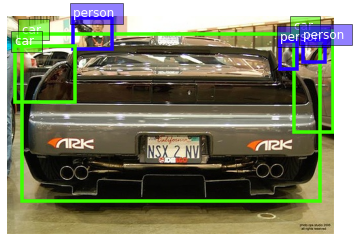

Score:  0.441025506781351
Score:  0.47300814944526093
Score:  0.4778346223422534
Score:  0.4920740296335968
Score:  0.05604921905040339
Score:  0.010843246761383263
Score:  1.1457694268462593
Score:  4.6545260846789125
Score:  4.673053760105092
Score:  0.9498063534844046
Score:  2.623601346362325
Score:  2.8803855284075417
Score:  1.1289688072483588
Score:  4.610253135047636
Score:  4.62863574529441
Score:  0.9345400557990065
Score:  2.5952298228272217
Score:  2.8500034750795704
Score:  1.6447697994537034
Score:  5.96949058546423
Score:  5.99232688642377
Score:  1.4032353588230988
Score:  3.466272697437171
Score:  3.782772243545799
Score:  0.046860845787727534
Score:  1.7586850131590843
Score:  1.7677241474316037
Score:  0.04874405292884476
Score:  0.7678536765367951
Score:  0.8931314918684543
Score:  1.8157164927057705
Score:  6.419968872641669
Score:  6.444281215159135
Score:  1.5585702911042043
Score:  3.7549536060540873
Score:  4.091910339338032
image: (375, 500, 3)
bboxes: (6, 4) 

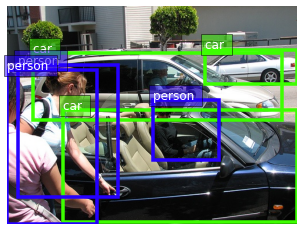

Score:  0.6999030812076044
Score:  0.8575142395359161
Score:  0.8157347948678999
Score:  0.8639147806258386
Score:  0.8671689326544594
Score:  0.9109463997099475
Score:  0.15200031709426032
Score:  0.4530312343873326
Score:  0.2926499359079817
Score:  0.4776013812413442
Score:  0.4900932928008813
Score:  0.6581445214920829
Score:  0.1429805599563243
Score:  0.4573138073646621
Score:  0.2981882380203512
Score:  0.48169157861410306
Score:  0.4940856829015555
Score:  0.6608211296029138
Score:  0.419898899431139
Score:  0.32583321654321395
Score:  0.12815512060781664
Score:  0.3561171704268985
Score:  0.371514085872128
Score:  0.5786457603395088
Score:  0.4379712884279834
Score:  0.7331492482720642
Score:  0.6549037016285026
Score:  0.745136335232532
Score:  0.7512307892484711
Score:  0.8332182801700401
Score:  0.5116751370682064
Score:  0.2822579373804963
Score:  0.07180276843273281
Score:  0.31449931749314164
Score:  0.3308914241955411
Score:  0.5514112108628102
image: (333, 500, 3)
bbox

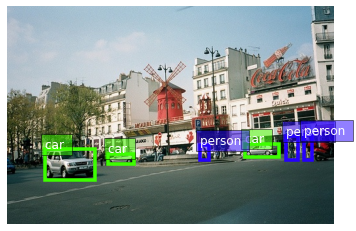

Score:  0.5644182947644389
Score:  0.0476561242336927
Score:  0.16101657725834018
Score:  0.8127609212709002
Score:  0.6136037565376001
Score:  0.24915647774580973
Score:  0.6720940173962902
Score:  2.6558204305473967
Score:  2.2206567562389488
Score:  0.2812339462319532
Score:  0.4832827900530752
Score:  3.7952130406877966
Score:  0.6590021095860978
Score:  2.6271966429197895
Score:  2.1954401470637
Score:  0.28686163152663524
Score:  0.47166920771752063
Score:  3.7576682098315315
Score:  1.060940799942609
Score:  3.505984355061063
Score:  2.969623025073323
Score:  0.1140843335286984
Score:  0.8282213727630265
Score:  4.91034361534237
Score:  0.184232128863538
Score:  0.783572465936299
Score:  0.5712682889622662
Score:  0.6493341597857354
Score:  0.276347842079401
Score:  1.3394502301604634
Score:  1.1941512649181356
Score:  3.797232056657756
Score:  3.2262026070595207
Score:  0.056822505404847234
Score:  0.9463898418188774
Score:  5.292363138264532
image: (483, 500, 3)
bboxes: (6, 4)

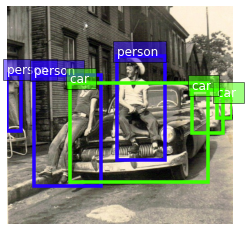

Score:  0.8557972518292223
Score:  0.6921304320650326
Score:  0.5532604395898568
Score:  0.5913158674709696
Score:  0.6410782172522344
Score:  0.5606052803676864
Score:  0.44644012911868247
Score:  0.1818376586868926
Score:  0.7149263555320331
Score:  0.568840667073073
Score:  0.3778149046025483
Score:  0.686731267961274
Score:  0.4507743081311073
Score:  0.17258428566290718
Score:  0.7014990855853018
Score:  0.5565571966650011
Score:  0.36702709869995087
Score:  0.6735247556294472
Score:  0.31770934454585475
Score:  0.4566749383442106
Score:  1.1137338320942032
Score:  0.933675801564559
Score:  0.6982268473671804
Score:  1.0789819546710566
Score:  0.7299336324887988
Score:  0.42341448457714814
Score:  0.16333542991403682
Score:  0.23460654854601404
Score:  0.3278026714682496
Score:  0.17709102399236498
Score:  0.27360897278164165
Score:  0.5508282230287747
Score:  1.250356614570833
Score:  1.058660397262559
Score:  0.8079930221054383
Score:  1.2133585233066881
image: (375, 500, 3)
bbo

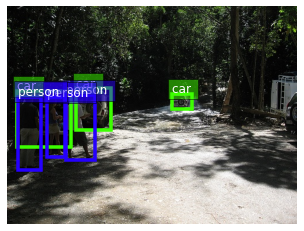

Score:  0.43367665869695093
Score:  0.3176474835228381
Score:  0.5018045846476296
Score:  0.9038585134057227
Score:  0.9064535153007812
Score:  0.8830668941259766
Score:  1.1739798975087825
Score:  1.6193881580488787
Score:  0.9124530793928982
Score:  0.6309358207068416
Score:  0.6408974125085748
Score:  0.5511217656357185
Score:  1.1569583998517814
Score:  1.5988792704340034
Score:  0.897479244700446
Score:  0.6338254633711184
Score:  0.6437090594141477
Score:  0.5546363242676846
Score:  1.6795406373187358
Score:  2.2285289401463233
Score:  1.3571955513806326
Score:  0.5451096547268277
Score:  0.557387822558882
Score:  0.4467347781986025
Score:  0.060623944845972444
Score:  0.2779261687084684
Score:  0.0669676698837417
Score:  0.8199439165965565
Score:  0.8248038984233466
Score:  0.7810048730291831
Score:  1.8527347699342815
Score:  2.437207346297443
Score:  1.5095546659395769
Score:  0.5157074737382206
Score:  0.5287792502202667
Score:  0.41097406277533344
image: (375, 500, 3)
bboxes

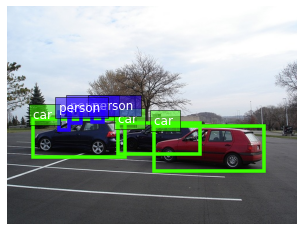

Score:  0.1347961537775204
Score:  0.08033766257418162
Score:  0.6062981969020443
Score:  0.3797473008913327
Score:  0.45029001954618175
Score:  0.4438407758364554
Score:  2.3213106925932445
Score:  2.530363819120417
Score:  0.5113270867108939
Score:  1.3810018074396226
Score:  1.110205177517221
Score:  1.1349622820837046
Score:  2.295305998512618
Score:  2.5027223126168936
Score:  0.4994939274002257
Score:  1.3623594010709663
Score:  1.093683013477866
Score:  1.1182462786266734
Score:  3.09368411371379
Score:  3.35135270969759
Score:  0.8627873927274976
Score:  1.9347056556846822
Score:  1.6009350558932427
Score:  1.6314494446528904
Score:  0.6203745273238552
Score:  0.7223656966045446
Score:  0.26266581466703565
Score:  0.16162414040068263
Score:  0.029510043941733066
Score:  0.04158834233738862
Score:  3.3582824778521134
Score:  3.6326056781222418
Score:  0.9831900625871508
Score:  2.1243925719565864
Score:  1.7690484573923713
Score:  1.8015351667132062
image: (333, 500, 3)
bboxes: 

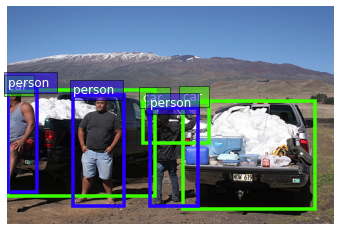

Score:  0.5784565587789379
Score:  0.6645181244782168
Score:  0.7623983740832189
Score:  0.39458004415905057
Score:  0.7845382582411019
Score:  0.5645527213935118
Score:  0.6182044784392327
Score:  0.28783470532008915
Score:  0.08790416942734824
Score:  1.3240624525920324
Score:  0.17289389099111985
Score:  5.005943807783225
Score:  0.6055345067574036
Score:  0.277751412717278
Score:  0.09504555884904597
Score:  1.3058658613370486
Score:  0.1793698407976101
Score:  4.958919381030516
Score:  0.9945192061977555
Score:  0.5873216817731122
Score:  0.1242044353533549
Score:  1.8645250089585255
Score:  0.019450287007505063
Score:  6.402630777243866
Score:  0.21052332661567086
Score:  0.3717014922578761
Score:  0.555013972756562
Score:  0.13384502283632993
Score:  0.5964780791448613
Score:  1.9301318844916096
Score:  1.1234364613016479
Score:  0.6899194173803744
Score:  0.1968682380036495
Score:  2.0496757461306054
Score:  0.08534322617173817
Score:  6.881105407813682
image: (375, 500, 3)
bbo

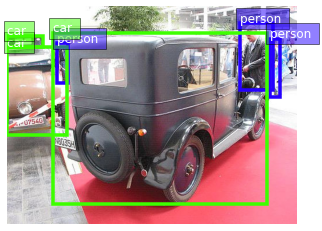

Score:  0.26989568325426516
Score:  0.7623063161076931
Score:  0.6898471978050238
Score:  0.5049432883060062
Score:  0.6523643463592724
Score:  0.707153181618964
Score:  3.8748258918232388
Score:  0.08755078087066626
Score:  0.19060244908232526
Score:  0.9004043465226477
Score:  0.3344901535108218
Score:  0.1241689151376495
Score:  3.836657720355305
Score:  0.09469493720041888
Score:  0.1812804508335386
Score:  0.8855248491690808
Score:  0.32404156516494753
Score:  0.11536706808422625
Score:  5.00847049780098
Score:  0.12464000469761505
Score:  0.4674779876589976
Score:  1.3423448761784238
Score:  0.6448268912383168
Score:  0.3855952829985543
Score:  1.3782911119590802
Score:  0.5548415643706882
Score:  0.41913838865942377
Score:  0.07284590942122982
Score:  0.3489396049169138
Score:  0.4515494504743026
Score:  5.396832525873835
Score:  0.19733196070140724
Score:  0.5623295355942171
Score:  1.4937441061308125
Score:  0.7511415194858668
Score:  0.4751542804822635
image: (334, 500, 3)
bb

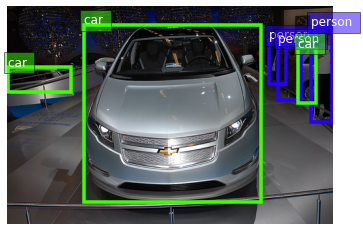

Score:  0.0815142899074508
Score:  0.7306575926659007
Score:  0.767705976464272
Score:  0.8178243755262203
Score:  0.7007608938295091
Score:  0.7793710570943371
Score:  3.151674765368928
Score:  0.03394110110962045
Score:  0.10827878590321183
Score:  0.3006713364297394
Score:  0.14870737954455704
Score:  0.15305824128329715
Score:  3.11916861277187
Score:  0.02584570609231518
Score:  0.1152606492469529
Score:  0.3061468337984481
Score:  0.1397134049489761
Score:  0.15968949724759218
Score:  4.117150006531664
Score:  0.27438491965453693
Score:  0.09909168574632243
Score:  0.13804190414748496
Score:  0.41584018665707223
Score:  0.04389873269949929
Score:  1.025485917514231
Score:  0.49556907556784613
Score:  0.5649541778735079
Score:  0.6588171184334719
Score:  0.4395778204930223
Score:  0.5868008208289947
Score:  4.447900861548259
Score:  0.3567557513202051
Score:  0.1701323068612426
Score:  0.08232859169274065
Score:  0.5073540863289492
Score:  0.11137191561389237
image: (375, 500, 3)


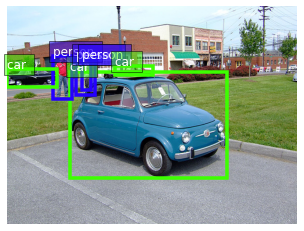

In [ ]:
l=10
similarity=cosine_sim(intermediate_ans,b)
if(l>len(similarity)):
  l=len(similarity)
for i in range(0,l):
  train_image, train_label = train_data[similarity[i][0]]
  bboxes = train_label[:, :4]
  cids = train_label[:, 4:5]
  for q_idx,qc in enumerate(cids_Q):
    for r_idx,rc in enumerate(cids):
      qbox=bboxes_Q[q_idx]
      ql=np.linalg.norm(np.array([qbox[0],qbox[1]])-np.array([qbox[2],qbox[3]]))
      rbox=bboxes[r_idx]
      rl=np.linalg.norm(np.array([rbox[0],rbox[1]])-np.array([rbox[2],rbox[3]]))
      #print("Score: ",np.sqrt(((1 - rl/ql) ** 2)))
  print('image:', train_image.shape)
  print('bboxes:', bboxes.shape, 'class ids:', cids.shape)
  ax = viz.plot_bbox(
      train_image.asnumpy(),
      bboxes,
      labels=cids,
      class_names=train_data.classes)
  ax.set_axis_off()
  plt.savefig('/content/drive/MyDrive/input_image_R_COS_{}.png'.format(i), format='png')
  plt.show()

Score:  0.7324577876650697
Score:  0.7505183475944152
Score:  0.4490874452224982
Score:  0.8383444745523703
Score:  0.8409022067004431
Score:  0.5834817163056385
Score:  5.650491210552056
Score:  0.042299588289819945
Score:  1.1148215728064086
Score:  0.37944309016868294
Score:  0.38926161232305556
Score:  0.5989141002257448
Score:  5.598420204427281
Score:  0.049798045535314306
Score:  1.0982632640162722
Score:  0.38430183242238725
Score:  0.39404347900305403
Score:  0.5863951654177799
Score:  7.197068186888936
Score:  0.18041439780330126
Score:  1.6066249975479376
Score:  0.23513209134665647
Score:  0.2472339185720157
Score:  0.9707428353161658
Score:  2.244588522176385
Score:  0.5327647740383212
Score:  0.03176225399583554
Score:  0.6972476523536671
Score:  0.7020378345038616
Score:  0.21993456223096142
Score:  7.726891879370536
Score:  0.2567113738249138
Score:  1.7751061727228197
Score:  0.18569427646162529
Score:  0.19857831442869456
Score:  1.098123286732803
image: (333, 500, 3)

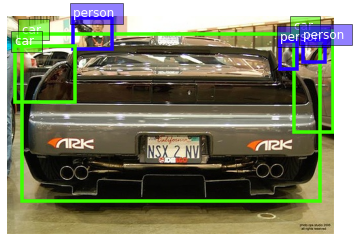

Score:  0.5952560233330711
Score:  0.470635163762658
Score:  0.869160266875155
Score:  0.8629536017397719
Score:  0.25203018796329524
Score:  0.5557157456812669
Score:  0.8859557467104217
Score:  0.5537153508225525
Score:  1.0321050334603505
Score:  0.49773754873963993
Score:  0.4739116453187331
Score:  1.8712772663930881
Score:  0.7055010225187852
Score:  0.5622113799733504
Score:  0.541550306318701
Score:  1.016194366068503
Score:  0.5016700870060354
Score:  0.47803073202548885
Score:  1.8487961756900346
Score:  0.6921475496131331
Score:  0.5656391108270645
Score:  0.9150330810904599
Score:  1.504672661737417
Score:  0.38093601955856227
Score:  0.35156938350534483
Score:  2.538995059303971
Score:  1.1021166304548502
Score:  0.46040329109696376
Score:  0.24198576700477403
Score:  0.008592830412146424
Score:  0.7549602077672298
Score:  0.7433362163472728
Score:  0.40081581458878013
Score:  0.16793378608717968
Score:  0.7864151854792099
Score:  1.0388126904720978
Score:  1.6665640706953

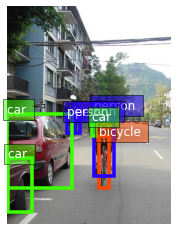

Score:  0.756660639781431
Score:  0.03406954428743436
Score:  0.7661337882519531
Score:  0.6231196837480075
Score:  0.7787769026714035
Score:  0.4168800304665208
Score:  0.6369420073270782
Score:  5.743400172846075
Score:  2.969545731126739
Score:  0.10224353127143693
Score:  0.44675342078148006
Score:  0.15077742451791076
Score:  1.2384581371569405
Score:  0.3936928255239711
Score:  5.690601722237653
Score:  2.938465584783546
Score:  0.10927264853536922
Score:  0.4354258505540325
Score:  0.15742653847494648
Score:  1.2209317975709242
Score:  0.3827807010873929
Score:  7.311583201642852
Score:  3.8926667217290776
Score:  0.10653044360279496
Score:  0.7831970698561659
Score:  0.04670995520258403
Score:  1.759013342451842
Score:  0.7177971913219889
Score:  2.2899162044667083
Score:  0.9366302592856075
Score:  0.5620097460583662
Score:  0.2941694989327933
Score:  0.5856880741665499
Score:  0.09208107329997506
Score:  0.32005627825507876
Score:  7.848808658581962
Score:  4.208907930108263


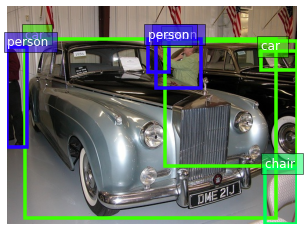

Score:  0.441025506781351
Score:  0.47300814944526093
Score:  0.4778346223422534
Score:  0.4920740296335968
Score:  0.05604921905040339
Score:  0.010843246761383263
Score:  1.1457694268462593
Score:  4.6545260846789125
Score:  4.673053760105092
Score:  0.9498063534844046
Score:  2.623601346362325
Score:  2.8803855284075417
Score:  1.1289688072483588
Score:  4.610253135047636
Score:  4.62863574529441
Score:  0.9345400557990065
Score:  2.5952298228272217
Score:  2.8500034750795704
Score:  1.6447697994537034
Score:  5.96949058546423
Score:  5.99232688642377
Score:  1.4032353588230988
Score:  3.466272697437171
Score:  3.782772243545799
Score:  0.046860845787727534
Score:  1.7586850131590843
Score:  1.7677241474316037
Score:  0.04874405292884476
Score:  0.7678536765367951
Score:  0.8931314918684543
Score:  1.8157164927057705
Score:  6.419968872641669
Score:  6.444281215159135
Score:  1.5585702911042043
Score:  3.7549536060540873
Score:  4.091910339338032
image: (375, 500, 3)
bboxes: (6, 4) 

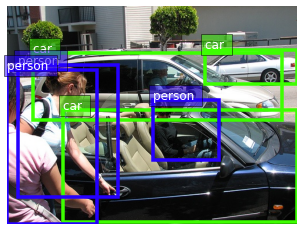

Score:  0.6999030812076044
Score:  0.8575142395359161
Score:  0.8157347948678999
Score:  0.8639147806258386
Score:  0.8671689326544594
Score:  0.9109463997099475
Score:  0.15200031709426032
Score:  0.4530312343873326
Score:  0.2926499359079817
Score:  0.4776013812413442
Score:  0.4900932928008813
Score:  0.6581445214920829
Score:  0.1429805599563243
Score:  0.4573138073646621
Score:  0.2981882380203512
Score:  0.48169157861410306
Score:  0.4940856829015555
Score:  0.6608211296029138
Score:  0.419898899431139
Score:  0.32583321654321395
Score:  0.12815512060781664
Score:  0.3561171704268985
Score:  0.371514085872128
Score:  0.5786457603395088
Score:  0.4379712884279834
Score:  0.7331492482720642
Score:  0.6549037016285026
Score:  0.745136335232532
Score:  0.7512307892484711
Score:  0.8332182801700401
Score:  0.5116751370682064
Score:  0.2822579373804963
Score:  0.07180276843273281
Score:  0.31449931749314164
Score:  0.3308914241955411
Score:  0.5514112108628102
image: (333, 500, 3)
bbox

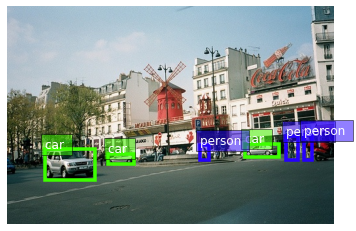

Score:  0.5644182947644389
Score:  0.0476561242336927
Score:  0.16101657725834018
Score:  0.8127609212709002
Score:  0.6136037565376001
Score:  0.24915647774580973
Score:  0.6720940173962902
Score:  2.6558204305473967
Score:  2.2206567562389488
Score:  0.2812339462319532
Score:  0.4832827900530752
Score:  3.7952130406877966
Score:  0.6590021095860978
Score:  2.6271966429197895
Score:  2.1954401470637
Score:  0.28686163152663524
Score:  0.47166920771752063
Score:  3.7576682098315315
Score:  1.060940799942609
Score:  3.505984355061063
Score:  2.969623025073323
Score:  0.1140843335286984
Score:  0.8282213727630265
Score:  4.91034361534237
Score:  0.184232128863538
Score:  0.783572465936299
Score:  0.5712682889622662
Score:  0.6493341597857354
Score:  0.276347842079401
Score:  1.3394502301604634
Score:  1.1941512649181356
Score:  3.797232056657756
Score:  3.2262026070595207
Score:  0.056822505404847234
Score:  0.9463898418188774
Score:  5.292363138264532
image: (483, 500, 3)
bboxes: (6, 4)

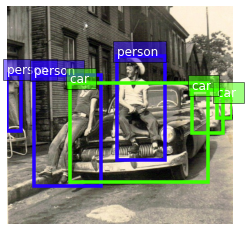

Score:  0.8557972518292223
Score:  0.6921304320650326
Score:  0.5532604395898568
Score:  0.5913158674709696
Score:  0.6410782172522344
Score:  0.5606052803676864
Score:  0.44644012911868247
Score:  0.1818376586868926
Score:  0.7149263555320331
Score:  0.568840667073073
Score:  0.3778149046025483
Score:  0.686731267961274
Score:  0.4507743081311073
Score:  0.17258428566290718
Score:  0.7014990855853018
Score:  0.5565571966650011
Score:  0.36702709869995087
Score:  0.6735247556294472
Score:  0.31770934454585475
Score:  0.4566749383442106
Score:  1.1137338320942032
Score:  0.933675801564559
Score:  0.6982268473671804
Score:  1.0789819546710566
Score:  0.7299336324887988
Score:  0.42341448457714814
Score:  0.16333542991403682
Score:  0.23460654854601404
Score:  0.3278026714682496
Score:  0.17709102399236498
Score:  0.27360897278164165
Score:  0.5508282230287747
Score:  1.250356614570833
Score:  1.058660397262559
Score:  0.8079930221054383
Score:  1.2133585233066881
image: (375, 500, 3)
bbo

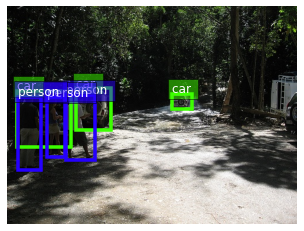

Score:  0.43367665869695093
Score:  0.3176474835228381
Score:  0.5018045846476296
Score:  0.9038585134057227
Score:  0.9064535153007812
Score:  0.8830668941259766
Score:  1.1739798975087825
Score:  1.6193881580488787
Score:  0.9124530793928982
Score:  0.6309358207068416
Score:  0.6408974125085748
Score:  0.5511217656357185
Score:  1.1569583998517814
Score:  1.5988792704340034
Score:  0.897479244700446
Score:  0.6338254633711184
Score:  0.6437090594141477
Score:  0.5546363242676846
Score:  1.6795406373187358
Score:  2.2285289401463233
Score:  1.3571955513806326
Score:  0.5451096547268277
Score:  0.557387822558882
Score:  0.4467347781986025
Score:  0.060623944845972444
Score:  0.2779261687084684
Score:  0.0669676698837417
Score:  0.8199439165965565
Score:  0.8248038984233466
Score:  0.7810048730291831
Score:  1.8527347699342815
Score:  2.437207346297443
Score:  1.5095546659395769
Score:  0.5157074737382206
Score:  0.5287792502202667
Score:  0.41097406277533344
image: (375, 500, 3)
bboxes

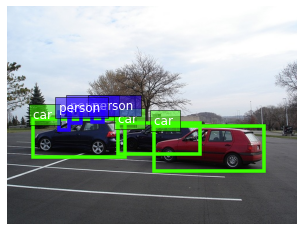

Score:  0.1347961537775204
Score:  0.08033766257418162
Score:  0.6062981969020443
Score:  0.3797473008913327
Score:  0.45029001954618175
Score:  0.4438407758364554
Score:  2.3213106925932445
Score:  2.530363819120417
Score:  0.5113270867108939
Score:  1.3810018074396226
Score:  1.110205177517221
Score:  1.1349622820837046
Score:  2.295305998512618
Score:  2.5027223126168936
Score:  0.4994939274002257
Score:  1.3623594010709663
Score:  1.093683013477866
Score:  1.1182462786266734
Score:  3.09368411371379
Score:  3.35135270969759
Score:  0.8627873927274976
Score:  1.9347056556846822
Score:  1.6009350558932427
Score:  1.6314494446528904
Score:  0.6203745273238552
Score:  0.7223656966045446
Score:  0.26266581466703565
Score:  0.16162414040068263
Score:  0.029510043941733066
Score:  0.04158834233738862
Score:  3.3582824778521134
Score:  3.6326056781222418
Score:  0.9831900625871508
Score:  2.1243925719565864
Score:  1.7690484573923713
Score:  1.8015351667132062
image: (333, 500, 3)
bboxes: 

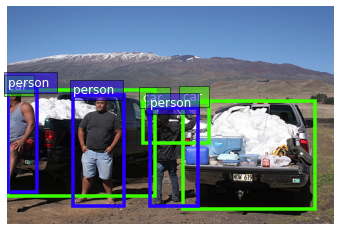

Score:  0.5784565587789379
Score:  0.6645181244782168
Score:  0.7623983740832189
Score:  0.39458004415905057
Score:  0.7845382582411019
Score:  0.5645527213935118
Score:  0.6182044784392327
Score:  0.28783470532008915
Score:  0.08790416942734824
Score:  1.3240624525920324
Score:  0.17289389099111985
Score:  5.005943807783225
Score:  0.6055345067574036
Score:  0.277751412717278
Score:  0.09504555884904597
Score:  1.3058658613370486
Score:  0.1793698407976101
Score:  4.958919381030516
Score:  0.9945192061977555
Score:  0.5873216817731122
Score:  0.1242044353533549
Score:  1.8645250089585255
Score:  0.019450287007505063
Score:  6.402630777243866
Score:  0.21052332661567086
Score:  0.3717014922578761
Score:  0.555013972756562
Score:  0.13384502283632993
Score:  0.5964780791448613
Score:  1.9301318844916096
Score:  1.1234364613016479
Score:  0.6899194173803744
Score:  0.1968682380036495
Score:  2.0496757461306054
Score:  0.08534322617173817
Score:  6.881105407813682
image: (375, 500, 3)
bbo

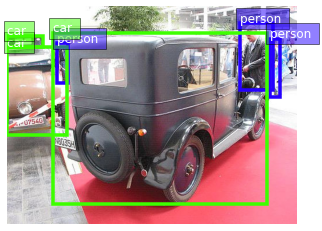

In [ ]:
l=10
similarity=dot_sim(intermediate_ans,b)
if(l>len(similarity)):
  l=len(similarity)
for i in range(0,l):
  train_image, train_label = train_data[similarity[i][0]]
  bboxes = train_label[:, :4]
  cids = train_label[:, 4:5]
  for q_idx,qc in enumerate(cids_Q):
    for r_idx,rc in enumerate(cids):
      qbox=bboxes_Q[q_idx]
      ql=np.linalg.norm(np.array([qbox[0],qbox[1]])-np.array([qbox[2],qbox[3]]))
      rbox=bboxes[r_idx]
      rl=np.linalg.norm(np.array([rbox[0],rbox[1]])-np.array([rbox[2],rbox[3]]))
      #print("Score: ",np.sqrt(((1 - rl/ql) ** 2)))
  print('image:', train_image.shape)
  print('bboxes:', bboxes.shape, 'class ids:', cids.shape)
  ax = viz.plot_bbox(
      train_image.asnumpy(),
      bboxes,
      labels=cids,
      class_names=train_data.classes)
  ax.set_axis_off()
  plt.savefig('/content/drive/MyDrive/input_image_R_DOT_{}.png'.format(i))
  plt.show()